# Classification 

In this tutorial we are going to give a brief overview of pitfalls of machine learning and some insights as to how to solve these and apply it to a use case in Cardiovascular MRI.

The tutorial is subdivided into 2 hands-on tutorials:

1. Presenting the problem of overfitting to the training data
2. Classical ways of avoiding/reducing overfitting.

> **Tip**: if you are running this in Google Colab, you can enable GPU computation by clicking on **Runtime > Change runtime type** and selecting **GPU** under **Hardware accelerator**. This will significantly speed up training of neural networks.


In [1]:
#Installing necessary libraries
!pip install pydicom tf_clahe visualkeras
# Importing necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, os.path
import math
import pydicom as dicom
import tf_clahe
import visualkeras
%matplotlib inline

/bin/bash: /home/oj20/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Hands-on: Preparing the data and running the model

Data preparation is crucial in machine learning.

Preparing it conveniently to learn the task at hand will probably take you more time than designing the model itself. 

Practical steps to get a modest classifier are described in the following section. 

### ACCESSING THE DATA

The full raw MR dataset "Ohio State Cardiac MRI Raw Data" (OCMR) can be obtained from https://registry.opendata.aws/ocmr_data. 

We retrieve the preprocessed OCMR DICOM dataset from the Workshop's github. 

The data is saved in the Downloads/Workshop/DICOMfiles folder.

The list of DICOM files is often provided in an apparently unhelpful format with names such as dicom_3001.dcm, dicom_3002.dcm, dicom_3003.dcm ...  


In [2]:
#Get data from github repository
import os
def get_download_path():
    """Returns the default downloads path for linux or windows"""
    if os.name == 'nt':
        import winreg
        sub_key = r'SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\Shell Folders'
        downloads_guid = '{374DE290-123F-4565-9164-39C4925E467B}'
        with winreg.OpenKey(winreg.HKEY_CURRENT_USER, sub_key) as key:
            location = winreg.QueryValueEx(key, downloads_guid)[0]
        return location
    else:
        return os.path.join(os.path.expanduser('~'), 'Downloads')

downloadpath=get_download_path() #If for windows does not work please write out the folder you want to download the data to.
images_url = "https://media.githubusercontent.com/media/mrphys/MLinCHD_Workshop/master/Workshop2/data/DICOMfilesWorkshop2.zip"
#!wget {images_url} -P {downloadpath}
tmp_path=downloadpath+'/DICOMfilesWorkshop2.zip'
image_path=downloadpath+'/Workshop/'
#!unzip {tmp_path} -d {image_path}
image_path=downloadpath+'/Workshop/DICOMfiles/'

We prepare a small preprocessing function for cropping and normalizing the images:

In [3]:
#Small image preprocessing function 
#Crops to square, resize to 128x128 and contrast normalizes.
def image_preprocessing(image,imageSize = 128,normalization=0):
    #Crops to square
    minSz = min(image.shape[0], image.shape[1])
    startX = math.floor((image.shape[0]-minSz)/2)
    startY = math.floor((image.shape[1]-minSz)/2)
    image_resampled = image[startX:startX+minSz, startY:startY+minSz, tf.newaxis]
    #Resized to 128x128
    image_preproc = tf.image.resize(image_resampled, [imageSize,imageSize])
    image_preproc=image_preproc/np.max(image_preproc)
    if normalization>0:
        #Contrast Normalization
        image_preproc=tf_clahe.clahe(image_preproc*255)/255
    return image_preproc

The preprocessing function has the option to perform contrast normalization or not.

It is performed if `normalization` is >0.

Let's try both with `normalization` = 0 and with `normalization` = 1 to see the impact on the images and final classifier

In [4]:
#Case 1 No contrast normalization is performed 
normalization=1
#Case 2 With Contrast limited adaptive histogram equalization (CLAHE)
#normalization=1

imageSize = 128

#Load Short Axis
ShortAxisfolder=image_path+'/ShortAxis/'
SAXelements=np.zeros((len(os.listdir(ShortAxisfolder)),imageSize,imageSize,1))
for ii,file in enumerate(np.sort(os.listdir(ShortAxisfolder))):
    file_path = ShortAxisfolder+file
    # read file
    ds = dicom.dcmread(file_path)
    image = ds.pixel_array
    image_preproc=image_preprocessing(image,normalization=normalization)
    SAXelements[ii,:,:,:]=image_preproc
    

#Load Non Short Axis
nonShortAxisfolder=image_path+'/nonShortAxis/'
nonSAXelements=np.zeros((len(os.listdir(nonShortAxisfolder)),imageSize,imageSize,1))
for ii,file in enumerate(np.sort(os.listdir(nonShortAxisfolder))):
    file_path = nonShortAxisfolder+file
    # read file
    ds = dicom.dcmread(file_path)
    image = ds.pixel_array
    image_preproc=image_preprocessing(image,normalization=normalization)
    nonSAXelements[ii,:,:,:]=image_preproc

#Create labels
SAXLabels=np.ones((SAXelements.shape[0],1))
nonSAXLabels=np.zeros((nonSAXelements.shape[0],1))

2022-09-12 15:50:40.679334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:50:40.684657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:50:40.684783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:50:40.685245: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Assemble the data and split the machine learning sets

The assembling function is ran and the data is separated into :

    Training set : 60 %
    Validation set: 20 %
    Test set: rest



In [5]:
# Split the dataset into training, validation and test set
train_perc=60/100 
val_perc=20/100
nTrain_SAX=int(train_perc*SAXelements.shape[0]);nTrain_nonSAX=int(train_perc*nonSAXelements.shape[0])
nVal_SAX=int((train_perc+val_perc)*SAXelements.shape[0]);nVal_nonSAX=int((train_perc+val_perc)*nonSAXelements.shape[0]);

train_data=np.concatenate((SAXelements[:nTrain_SAX,:,:,:],nonSAXelements[:nTrain_nonSAX,:,:,:]),axis=0)
train_labels=np.concatenate((SAXLabels[:nTrain_SAX,:],nonSAXLabels[:nTrain_nonSAX,:]),axis=0)

val_data=np.concatenate((SAXelements[nTrain_SAX:nVal_SAX,:,:,:],nonSAXelements[nTrain_nonSAX:nVal_nonSAX,:,:,:]),axis=0)
val_labels=np.concatenate((SAXLabels[nTrain_SAX:nVal_SAX,:],nonSAXLabels[nTrain_nonSAX:nVal_nonSAX,:]),axis=0)

test_data=np.concatenate((SAXelements[nVal_SAX:,:,:,:],nonSAXelements[nVal_nonSAX:,:,:,:]),axis=0)
test_labels=np.concatenate((SAXLabels[nVal_SAX:,:],nonSAXLabels[nVal_nonSAX:,:]),axis=0)

print('Total: SAX',SAXelements.shape[0],'nonSAX',nonSAXelements.shape[0],
      '\nTrain: SAX',nTrain_SAX,'nonSAX',nTrain_nonSAX,
      '\nValidation: SAX',nVal_SAX-nTrain_SAX,'nonSAX',nVal_nonSAX-nTrain_nonSAX,
       '\nTest: SAX',SAXelements.shape[0]-nVal_SAX,'nonSAX',nonSAXelements.shape[0]-nVal_nonSAX,)


Total: SAX 32 nonSAX 42 
Train: SAX 19 nonSAX 25 
Validation: SAX 6 nonSAX 8 
Test: SAX 7 nonSAX 9


## Don't Forget to look at the images !

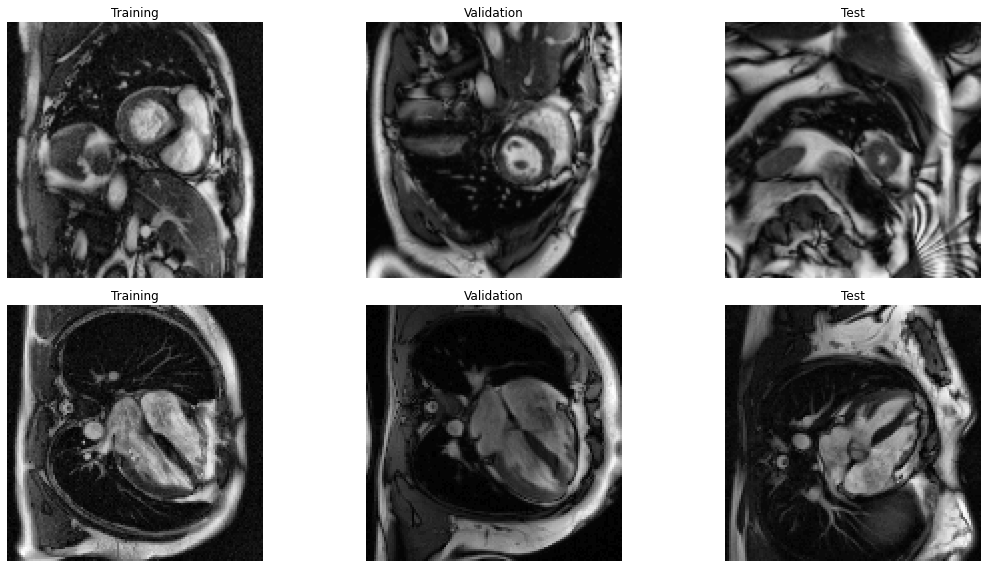

In [6]:
#Plot one image from each set
fig=plt.figure(figsize=(16,8))
plt.subplot(231)
plt.imshow(train_data[0,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Training')
plt.subplot(232)
plt.imshow(val_data[0,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Validation')
plt.subplot(233)
plt.imshow(test_data[0,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Test')
plt.subplot(234)
plt.imshow(train_data[-1,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Training')
plt.subplot(235)
plt.imshow(val_data[-1,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Validation')
plt.subplot(236)
plt.imshow(test_data[-1,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Test')
fig.tight_layout()

## Model Creation

Here we define the same function to create our base model as in the previous workshop.
The function creates a model with nLayers consisting each of
 - 2 convolutions and 1 max pooling.
 - nInitConvFilters in the first layer doubled for each layer.

for feature extraction followed by a dense layer for feature combination and logistic regression.


In [7]:
#Function to create different sized models
def create_base_model(train_data,nLayers=4,nInitConvFilters=8,kernelSize=3):
  # Determine and store the shape of the data
  input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3])
  # Create the model
  model = tf.keras.models.Sequential()

  #CNN layers with maxpooling
  for ii in range(nLayers):
    if ii ==0: #First Layer need to define an input size
      model.add(tf.keras.layers.Conv2D(nInitConvFilters*2**ii, kernel_size=(kernelSize, kernelSize), padding='same', activation='relu', input_shape=input_shape))
    else:
      model.add(tf.keras.layers.Conv2D(nInitConvFilters*2**ii, kernel_size=(kernelSize, kernelSize), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(nInitConvFilters*2**ii, kernel_size=(kernelSize, kernelSize), padding='same', activation='relu'))
    ## choose the best features via pooling
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  ## Reduce to 1 dimension for classification
  model.add(tf.keras.layers.Flatten())
  ## Fully connected to combine all features
  model.add(tf.keras.layers.Dense(nInitConvFilters*2**(ii+1), activation='relu'))
  ## Logistic Regression
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

## Ready to fit the model with the current dataset

In this section, we return to the model creation and this time we actually perform the fitting with the preprocessed data.

In [8]:
tf.random.set_seed(1)
np.random.seed(1)
model=create_base_model(train_data)

# Compile the model
loss_function=tf.keras.losses.binary_crossentropy
learning_rate=0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
# Define batches, number of epochs etc,
# Fit model to data
history = model.fit(train_data, train_labels,
            validation_data=(val_data,val_labels),
            batch_size=1,
            epochs=50,
            verbose=1,
            shuffle=True)

Epoch 1/50


2022-09-12 15:50:43.460675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-09-12 15:50:44.570647: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


44/44 [==============================] - 2s 5ms/step - loss: 0.6940 - accuracy: 0.5682 - val_loss: 0.6921 - val_accuracy: 0.5714
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5682 - val_loss: 0.6894 - val_accuracy: 0.5714
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5682 - val_loss: 0.6829 - val_accuracy: 0.5714
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.7045 - val_loss: 0.6750 - val_accuracy: 0.5714
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 0.5816 - accuracy: 0.7273 - val_loss: 0.5950 - val_accuracy: 0.6429
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 0.3615 - accuracy: 0.8864 - val_loss: 0.4084 - val_accuracy: 0.7857
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 0.1550 - accuracy: 0.9545 - val_loss: 0.5532 - val_accuracy: 0.7857
Epoch 8/50
44/44 [=============

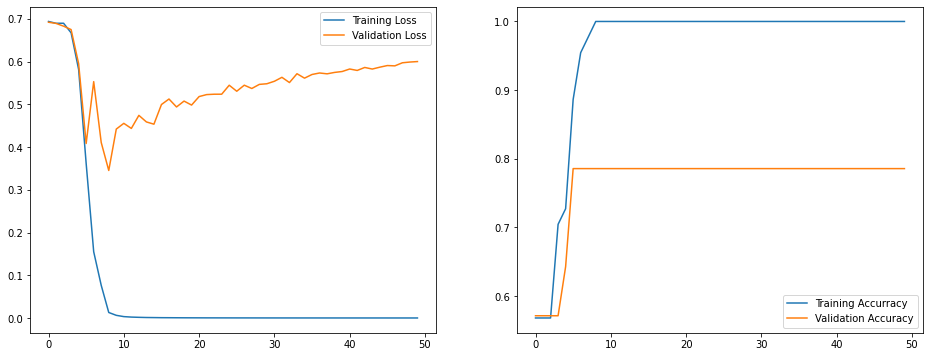

In [9]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)  # Plot the training curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()
plt.subplot(122)
# Plot the training curves
plt.plot(history.history['accuracy'], label='Training Accurracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
leg = plt.legend()


## Hands-on: Strategies to prevent over-fitting

Four strategies for reducing overfitting are presented

In this section we will observe 4 strategies to reduce overfitting:
- Early stopping consists in stopping before convergence is observed on the training dataset. It is often performed by evaluating on the validation set at multiple points during training to recover the trained network which performed best on unseen data (i.e. generalizes the best).
- Adding drop out layers which randomly sets inputs to zero with a dropout rate.
- Adding kernel regularization. This will seek simpler/sparser networks with lower weight values.
- Data augmentation (rotations, flips and small transformations of the image should not change the fact that it is a short axis or not)

### Early stopping
We can select the model which generalized the best to the unseen data.

For exemple with the best validation loss.

We could also take the one with the best accuracy or any other metric.

This is performed through callbacks (used to retrieve information during training)

`model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint()`


In [10]:
tf.random.set_seed(1)
np.random.seed(1)

# Create model
model=create_base_model(train_data)

# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])

# Define callbacks (Here we save the model with the best accuracy on the validation set)
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True, 
    monitor='val_loss', save_best_only=True)

# Fit model to data
history = model.fit(train_data, train_labels,
            validation_data=(val_data,val_labels),
            callbacks=[model_checkpoint_callback],
            batch_size=1,
            epochs=50,
            verbose=1,
            shuffle=True)
            


Epoch 1/50
44/44 [==============================] - 1s 5ms/step - loss: 0.6939 - accuracy: 0.5682 - val_loss: 0.6921 - val_accuracy: 0.5714
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5682 - val_loss: 0.6893 - val_accuracy: 0.5714
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5682 - val_loss: 0.6829 - val_accuracy: 0.5714
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.7045 - val_loss: 0.6735 - val_accuracy: 0.5714
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 0.5730 - accuracy: 0.7727 - val_loss: 0.5842 - val_accuracy: 0.6429
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 0.3524 - accuracy: 0.8636 - val_loss: 0.4090 - val_accuracy: 0.7857
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 0.1486 - accuracy: 0.9545 - val_loss: 0.5675 - val_accuracy: 0.7857
Epoch 8/50
44/44 [==

In [11]:
# Returned model is the last model
valeval0 = model.evaluate(val_data,val_labels)

#Here we load the 'best' model
model.load_weights(checkpoint_filepath)
valeval = model.evaluate(val_data,val_labels)


1/1 [==============================] - 0s 14ms/step - loss: 0.3317 - accuracy: 0.7857


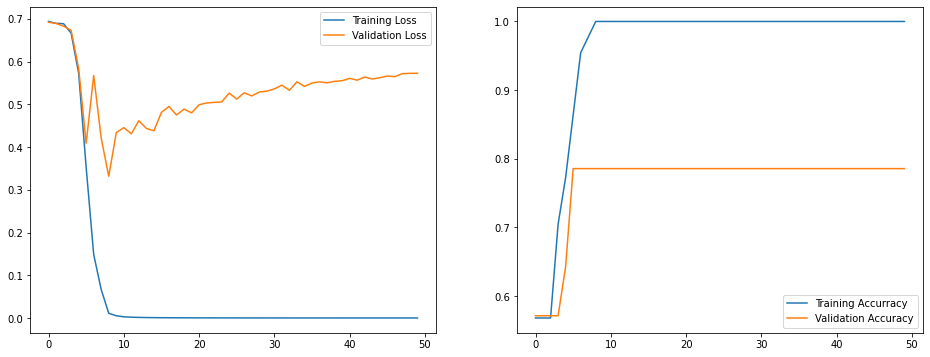

In [12]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)  # Plot the training curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()
plt.subplot(122)
# Plot the training curves
plt.plot(history.history['accuracy'], label='Training Accurracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
leg = plt.legend()

### Define new model creation function

To test the different strategies we need to implement the new models.

We define a function `create_new_model` which enables the options:
- `dropout` -> drop-out rate for drop-out layer -> usually between 0.2 and 0.5
- `kernel_regularizer` -> factor for l2 regularization of weights of all layers -> 0.0001 typical value
- `augment` -> adds random rotation, flip and zoom if augment>0 

In [13]:
#Function to create different sized models
def create_new_model(train_data,nLayers=4,nInitConvFilters=8,kernelSize=3,dropout=0,kernel_regularizer=None,augment=0):
  # New parameters
  # - `dropout` -> drop-out rate for drop-out layer -> usually between 0.2 and 0.5
  # - `kernel_regularizer` -> factor for l2 regularization of weights of all layers -> 0.0001 typical value
  # - `augment` -> adds random rotation, flip and zoom if augment>0 

  # Determine and store the shape of the data
  input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3])
  # Create the model
  model = tf.keras.models.Sequential()

  #Data augmentation option
  if augment>0:
    model.add(tf.keras.layers.RandomFlip("horizontal",input_shape=input_shape ))
    model.add(tf.keras.layers.RandomRotation(0.3))
    model.add(tf.keras.layers.RandomZoom(0.2))

  # Add L2 regularization if kernel_regularizer is not None
  if kernel_regularizer is not None:
    #recommended value=0.0001
    kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)
  #CNN layers with maxpooling
  for ii in range(nLayers):
    if ii ==0: #First Layer need to define an input size
      model.add(tf.keras.layers.Conv2D(nInitConvFilters*2**ii, kernel_size=(kernelSize, kernelSize), padding='same', activation='relu',kernel_regularizer=kernel_regularizer, input_shape=input_shape))
    else:
      model.add(tf.keras.layers.Conv2D(nInitConvFilters*2**ii, kernel_size=(kernelSize, kernelSize), padding='same', activation='relu',kernel_regularizer=kernel_regularizer))
    model.add(tf.keras.layers.Conv2D(nInitConvFilters*2**ii, kernel_size=(kernelSize, kernelSize), padding='same', activation='relu',kernel_regularizer=kernel_regularizer))
    ## choose the best features via pooling
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  if dropout>0:
    model.add(tf.keras.layers.Dropout(dropout))
  ## Reduce to 1 dimension for classification
  model.add(tf.keras.layers.Flatten())
  ## Fully connected to combine all features
  model.add(tf.keras.layers.Dense(nInitConvFilters*2**(ii+1), activation='relu',kernel_regularizer=kernel_regularizer))
  ## Logistic Regression
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

### Model + Dropout

In [14]:
tf.random.set_seed(1)
np.random.seed(1)

# Create model
model=create_new_model(train_data,dropout=0.3)

# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])

# Define callbacks (Here we save the model with the best accuracy on the validation set)
checkpoint_filepath1 = '/tmp/checkpointdropout'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath1, save_weights_only=True, monitor='val_loss', save_best_only=True)

# Fit model to data
history_dropout = model.fit(train_data, train_labels,
            validation_data=(val_data,val_labels),
            callbacks=[model_checkpoint_callback],
            batch_size=1,
            epochs=50,
            verbose=1,
            shuffle=True)


Epoch 1/50
44/44 [==============================] - 1s 6ms/step - loss: 0.6933 - accuracy: 0.4318 - val_loss: 0.6921 - val_accuracy: 0.5714
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5682 - val_loss: 0.6893 - val_accuracy: 0.5714
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5682 - val_loss: 0.6836 - val_accuracy: 0.5714
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5682 - val_loss: 0.6836 - val_accuracy: 0.5714
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.5682 - val_loss: 0.6719 - val_accuracy: 0.5714
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.7500 - val_loss: 0.6759 - val_accuracy: 0.5714
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 0.3957 - accuracy: 0.9091 - val_loss: 0.5254 - val_accuracy: 0.6429
Epoch 8/50
44/44 [==

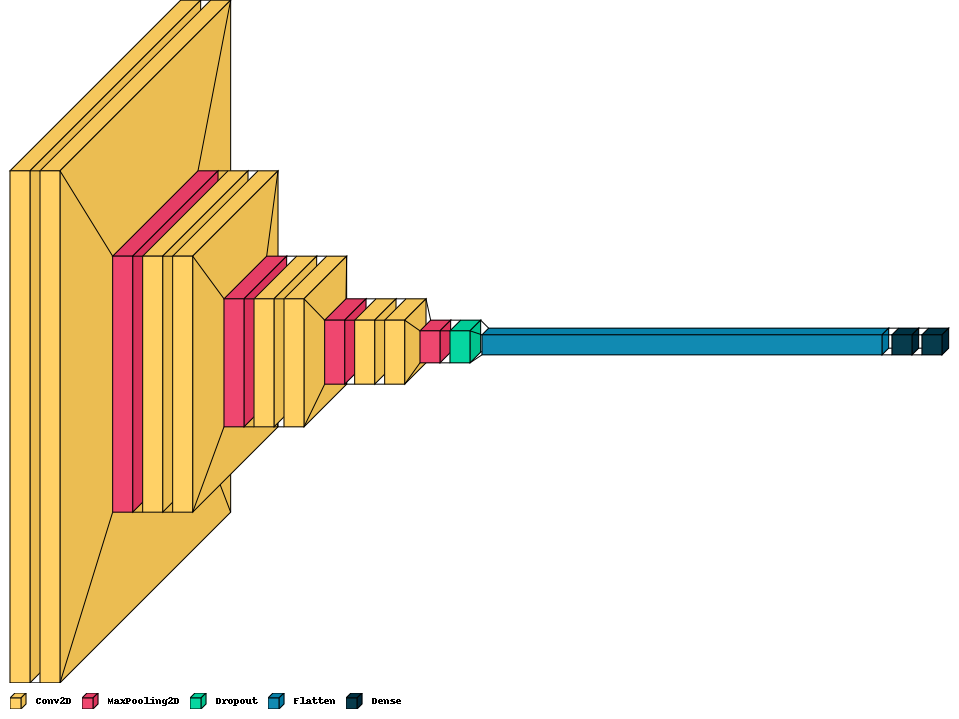

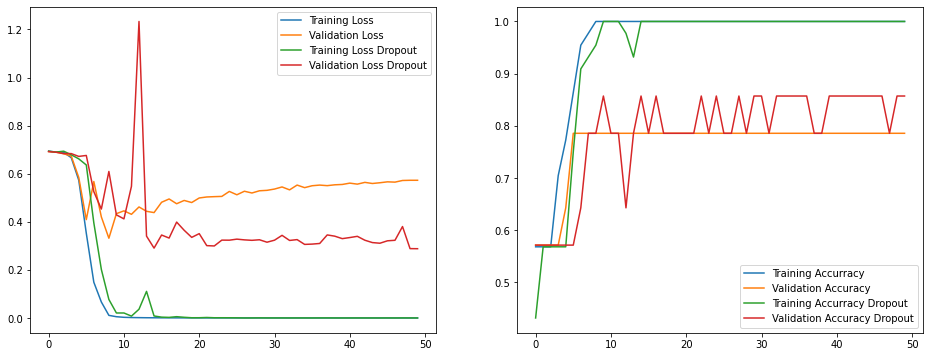

In [15]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)  # Plot the training curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_dropout.history['loss'], label='Training Loss Dropout')
plt.plot(history_dropout.history['val_loss'], label='Validation Loss Dropout')
leg = plt.legend()
plt.subplot(122)
# Plot the training curves
plt.plot(history.history['accuracy'], label='Training Accurracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_dropout.history['accuracy'], label='Training Accurracy Dropout')
plt.plot(history_dropout.history['val_accuracy'], label='Validation Accuracy Dropout')
leg = plt.legend()
visualkeras.layered_view(model, legend=True)

### Model + Kernel regularization

In [16]:
tf.random.set_seed(1)
np.random.seed(1)

#Create model with kernel regularization
model=create_new_model(train_data,kernel_regularizer=0.0001)

# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])

# Define callbacks (Here we save the model with the best accuracy on the validation set)
checkpoint_filepath2 = '/tmp/checkpointkerreg'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath2, save_weights_only=True, monitor='val_loss', save_best_only=True)
# Fit model to data
history_reg = model.fit(train_data, train_labels,
            validation_data=(val_data,val_labels),
            callbacks=[model_checkpoint_callback],
            batch_size=1,
            epochs=50,
            verbose=1,
            shuffle=True)


Epoch 1/50
44/44 [==============================] - 1s 6ms/step - loss: 0.7365 - accuracy: 0.5682 - val_loss: 0.7330 - val_accuracy: 0.5714
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 0.7290 - accuracy: 0.5682 - val_loss: 0.7269 - val_accuracy: 0.5714
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.7269 - accuracy: 0.5682 - val_loss: 0.7190 - val_accuracy: 0.5714
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 0.7043 - accuracy: 0.7273 - val_loss: 0.7106 - val_accuracy: 0.5714
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.7273 - val_loss: 0.6398 - val_accuracy: 0.6429
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 0.4065 - accuracy: 0.8864 - val_loss: 0.4522 - val_accuracy: 0.7857
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 0.1816 - accuracy: 0.9545 - val_loss: 0.5354 - val_accuracy: 0.7143
Epoch 8/50
44/44 [==

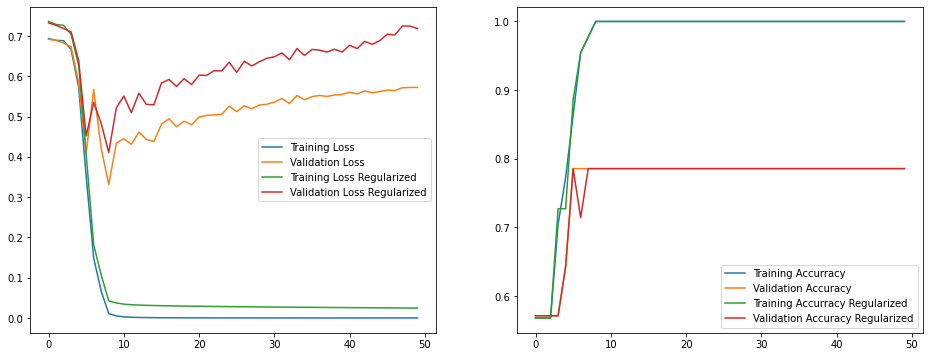

In [17]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)  # Plot the training curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_reg.history['loss'], label='Training Loss Regularized')
plt.plot(history_reg.history['val_loss'], label='Validation Loss Regularized')
leg = plt.legend()
plt.subplot(122)
# Plot the training curves
plt.plot(history.history['accuracy'], label='Training Accurracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_reg.history['accuracy'], label='Training Accurracy Regularized')
plt.plot(history_reg.history['val_accuracy'], label='Validation Accuracy Regularized')
leg = plt.legend()

### Model + Data Augmentation

In [18]:
tf.random.set_seed(1)
np.random.seed(1)

#Create model with data augmentation
model=create_new_model(train_data,augment=1)
# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])

# Define callbacks (Here we save the model with the best accuracy on the validation set)
checkpoint_filepath3 = '/tmp/checkpointaugment'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath3, save_weights_only=True, monitor='val_loss', save_best_only=True)
# Fit model to data
history_augment = model.fit(train_data, train_labels,
            validation_data=(val_data,val_labels),
            callbacks=[model_checkpoint_callback],
            batch_size=1,
            epochs=50,
            verbose=1,
            shuffle=True)


Epoch 1/50
44/44 [==============================] - 1s 6ms/step - loss: 0.6939 - accuracy: 0.6136 - val_loss: 0.6925 - val_accuracy: 0.5714
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5682 - val_loss: 0.6928 - val_accuracy: 0.5714
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5682 - val_loss: 0.6887 - val_accuracy: 0.5714
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5682 - val_loss: 0.6905 - val_accuracy: 0.5714
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5682 - val_loss: 0.6878 - val_accuracy: 0.5714
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5682 - val_loss: 0.6870 - val_accuracy: 0.5714
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5682 - val_loss: 0.6869 - val_accuracy: 0.5714
Epoch 8/50
44/44 [==

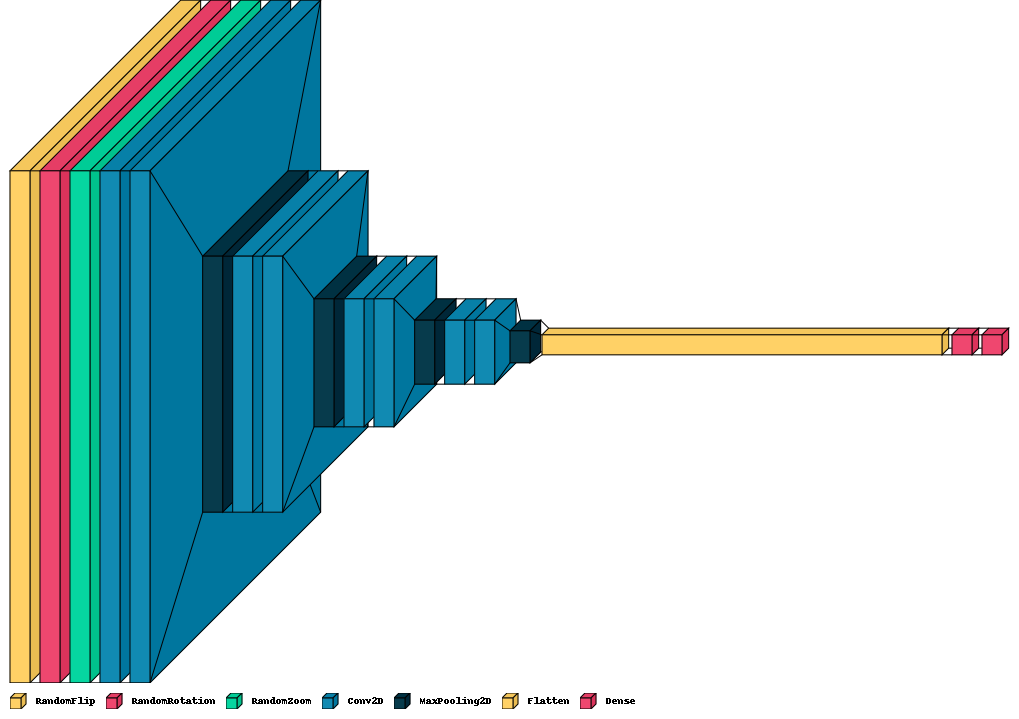

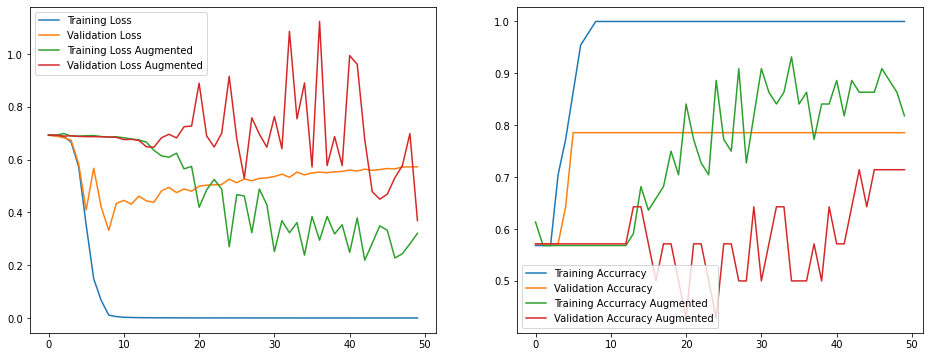

In [19]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)  # Plot the training curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_augment.history['loss'], label='Training Loss Augmented')
plt.plot(history_augment.history['val_loss'], label='Validation Loss Augmented')
leg = plt.legend()
plt.subplot(122)
# Plot the training curves
plt.plot(history.history['accuracy'], label='Training Accurracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_augment.history['accuracy'], label='Training Accurracy Augmented')
plt.plot(history_augment.history['val_accuracy'], label='Validation Accuracy Augmented')
leg = plt.legend()
visualkeras.layered_view(model, legend=True)

### Combined strategies

We now use all the strategies we've learned together:
- Early stopping
- Drop-out
- Kernel regularization
- Data augmentation

And create our final model.

In [20]:
tf.random.set_seed(1)
np.random.seed(1)


#Create model with data augmentation
model=create_new_model(train_data,augment=1,dropout=0.3,kernel_regularizer=0.0001)
# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])

# Define callbacks (Here we save the model with the best accuracy on the validation set)
checkpoint_filepath4 = '/tmp/checkpointfinal'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath4, save_weights_only=True, monitor='val_loss', save_best_only=True)
# Fit model to data
history_combined = model.fit(train_data, train_labels,
            validation_data=(val_data,val_labels),
            callbacks=[model_checkpoint_callback],
            batch_size=1,
            epochs=100,
            verbose=1,
            shuffle=True)
# Early stopping
model.load_weights(checkpoint_filepath4)

Epoch 1/100
44/44 [==============================] - 1s 7ms/step - loss: 0.7360 - accuracy: 0.5000 - val_loss: 0.7324 - val_accuracy: 0.5714
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7326 - accuracy: 0.5682 - val_loss: 0.7290 - val_accuracy: 0.5714
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7354 - accuracy: 0.5682 - val_loss: 0.7235 - val_accuracy: 0.5714
Epoch 4/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7251 - accuracy: 0.5682 - val_loss: 0.7228 - val_accuracy: 0.5714
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7224 - accuracy: 0.5682 - val_loss: 0.7194 - val_accuracy: 0.5714
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7241 - accuracy: 0.5682 - val_loss: 0.7175 - val_accuracy: 0.5714
Epoch 7/100
44/44 [==============================] - 0s 4ms/step - loss: 0.7239 - accuracy: 0.5682 - val_loss: 0.7177 - val_accuracy: 0.5714
Epoch 8/100
4

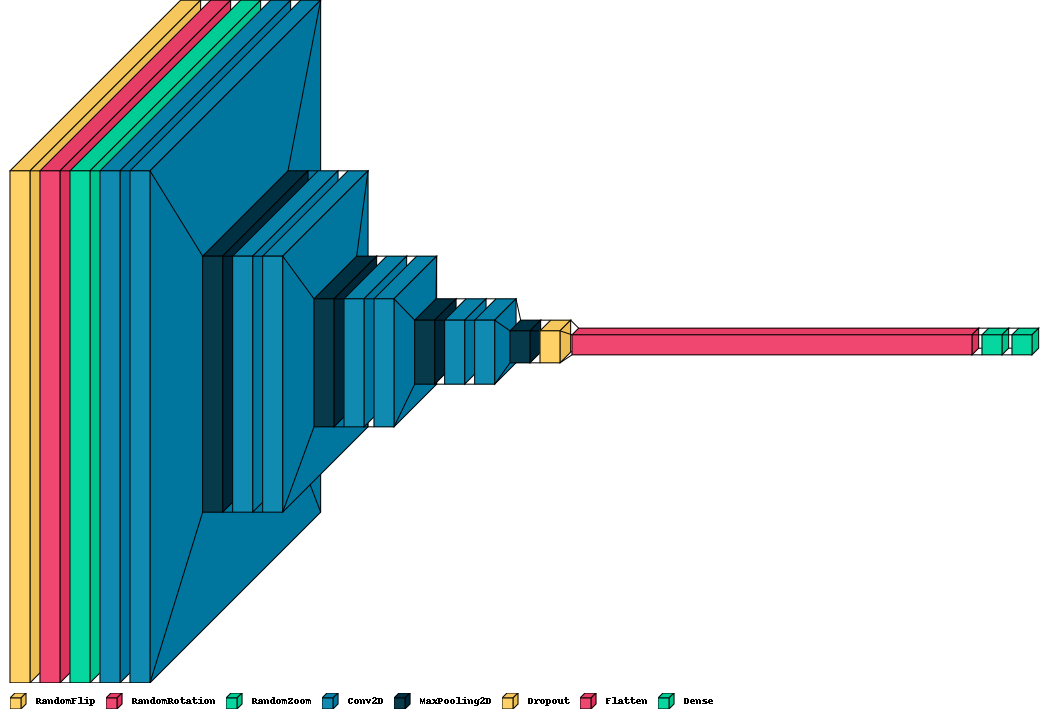

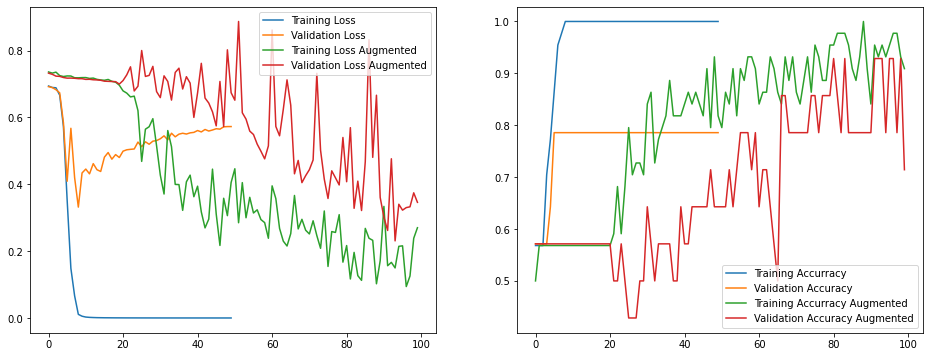

In [21]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)  # Plot the training curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_combined.history['loss'], label='Training Loss Augmented')
plt.plot(history_combined.history['val_loss'], label='Validation Loss Augmented')
leg = plt.legend()
plt.subplot(122)
# Plot the training curves
plt.plot(history.history['accuracy'], label='Training Accurracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_combined.history['accuracy'], label='Training Accurracy Augmented')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy Augmented')
leg = plt.legend()
visualkeras.layered_view(model, legend=True)

## Evaluation of the final Model on the test set

1/1 [==============================] - 0s 195ms/step - loss: 0.1347 - accuracy: 0.9375
[ True False False False False False False False False False False False
 False False False False]


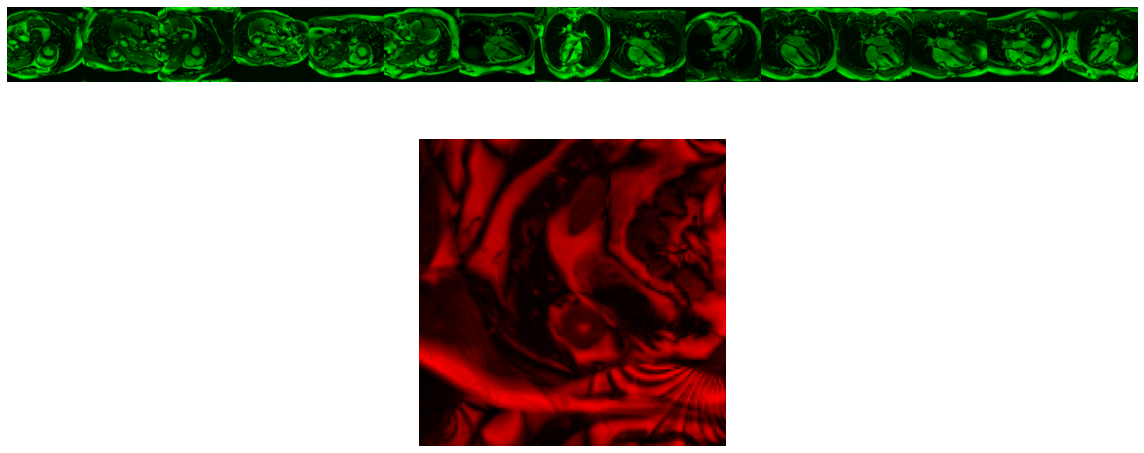

In [22]:
#Plot Test set (green correct, red incorrect)
## Evaluate the model on the test set

testeval = model.evaluate(test_data,test_labels)
results = model.predict(test_data)

#Visualize results
fig=plt.figure(figsize=(16,8))
plt.subplot(211)
indexes=np.squeeze((test_labels>0.5)==(results>0.5))
SelectedImages=test_data[indexes,:,:,0]
PositiveImages=np.reshape(SelectedImages,(-1,128))
PositiveImages=np.stack((np.zeros(PositiveImages.shape),PositiveImages,np.zeros(PositiveImages.shape)),axis=-1)
plt.imshow(np.transpose(PositiveImages,axes=(1,0,2)))
plt.axis('off')
indexes=np.squeeze((test_labels>0.5)!=(results>0.5))
print(indexes)
if any(indexes):
    plt.subplot(212)
    SelectedImages=test_data[indexes,:,:,0]
    NegativeImages=np.reshape(SelectedImages,(-1,128))
    NegativeImages=np.stack((NegativeImages,np.zeros(NegativeImages.shape),np.zeros(NegativeImages.shape)),axis=-1)
    plt.imshow(np.transpose(NegativeImages,axes=(1,0,2)))
    plt.axis('off')
fig.tight_layout()

### Model comparison
We can actually compare all the models we obtained during our tutorial by recreating the corresponding model and loading the corresponding best weights.

In [23]:
## Evaluate all the models on the test set

print('---Original model---')
model=create_new_model(train_data)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])
testevalori = model.evaluate(test_data,test_labels)

print('---Early stopping---')
model.load_weights(checkpoint_filepath)
testeval = model.evaluate(test_data,test_labels)

print('---Model + Dropout---')
model=create_new_model(train_data,dropout=0.3)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])
model.load_weights(checkpoint_filepath1)
testeval1 = model.evaluate(test_data,test_labels)

print('---Model + Regularization---')
model=create_new_model(train_data,kernel_regularizer=0.0001)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])
model.load_weights(checkpoint_filepath2)
testeval2 = model.evaluate(test_data,test_labels)

print('---Model + Augmentation---')
model=create_new_model(train_data,augment=1)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])
model.load_weights(checkpoint_filepath3)
testeval3 = model.evaluate(test_data,test_labels)

print('---Final Model ---')
model=create_new_model(train_data,augment=1,dropout=0.3,kernel_regularizer=0.0001)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])
model.load_weights(checkpoint_filepath4)
testeval4 = model.evaluate(test_data,test_labels)


---Original model---
1/1 [==============================] - 0s 139ms/step - loss: 0.6931 - accuracy: 0.4375
---Early stopping---
1/1 [==============================] - 0s 13ms/step - loss: 0.2057 - accuracy: 0.8750
---Model + Dropout---
1/1 [==============================] - 0s 142ms/step - loss: 0.3025 - accuracy: 0.8125
---Model + Regularization---
1/1 [==============================] - 0s 174ms/step - loss: 0.2249 - accuracy: 0.8750
---Model + Augmentation---
1/1 [==============================] - 0s 135ms/step - loss: 0.1480 - accuracy: 1.0000
---Final Model ---
1/1 [==============================] - 0s 183ms/step - loss: 0.1347 - accuracy: 0.9375


# Conclusion

In this tutorial, we looked at different ways of improving performance and generalizability of our network.
We used classical methods to reduce overfitting to the training set such as : 

1. Early stopping
2. Drop out layers to force the distribution of decision weights
3. Weight regularization to reduce the overfitting by penalizing high weights within the network.
4. Data augmentation to artificially increase the number of training data and help generalize to other data. 
5. Finally we combined all strategies and evaluated the final model with good performance.

Hopefully these strategies can help you improve your models and help reduce the amount of data needed.

